In [1]:
import numpy as np
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import copy

api = wandb.Api()
entity, project = "claire-labo", "pack"
task = "bin"
num_models = 1
sweep_specifier = "icml"
max_round_num = 2700 
linewidth = 3

llama32best = "s2"
qwensmallbest = "s0"
granitebest = "s2"
phibest = "s2"
prefix = "sweepfinalicml"

In [2]:
metric_key = "Number of unique scores in program bank"
results = {
    "qwensmall":{qwensmallbest:[], "b":[]}, 
    "granite":{granitebest:[], "b":[]}, 
    "phi":{phibest:[], "b":[]},
    "llama32":{llama32best:[], "b":[]},        
    }

# results = {"phi":{"b":[], phibest:[]}}

for model_name in results.keys():
    for sweep_identifier in results[model_name].keys():
        #model_name = "llama32"
        #sweep_identifier = "b" # "b", "s0", "s1", "s2""
        filters = {"config.config_specific": f"{num_models}m{model_name}{sweep_specifier}{sweep_identifier}"
                    , "config.task_name": task, "config.prefix": prefix} # "config.config_specific": "1llama32icmlb"
        runs = api.runs(entity + "/" + project, filters=filters)

        seeds = []
        for run in runs:
            print(run.name)
            seeds.append(run.config["seed"])
        seeds = list(set(seeds))

        histories = {}.fromkeys(seeds)
        histories = {seed: [] for seed in seeds}
        keys = [metric_key, "round_num"]
        for run in runs:
            # history = run.scan_history(keys=keys)
            history = run.history(keys=keys, pandas=True, samples=100, x_axis='round_num')
            s = run.config["seed"]
            histories[s].append(history)

        for seed in seeds:
            histories[seed] = copy.deepcopy([history for history in histories[seed] if not history.empty])
            # check if there are any duplicates, if there are drop the first row with the duplicate round_num
            for history in histories[seed]:
                history.drop_duplicates(subset="round_num", keep="last", inplace=True)
            assert all(histories[seed][i]["round_num"].duplicated().sum() == 0 for i in range(len(histories[seed]))), f"Seed {seed} has duplicates"

        for seed in seeds:
            if len(histories[seed]) != 1:    
                for i in range(1, len(histories[seed])):
                    print(seed, i)
                    histories[seed][i] = histories[seed][i].iloc[1:] if histories[seed][i].iloc[0]["round_num"] == histories[seed][i-1].iloc[-1]["round_num"] else histories[seed][i]
            histories[seed] = pd.concat(histories[seed])

        metrics = {}.fromkeys(keys)
        metrics = {key: [] for key in keys}

        for seed, history_df in histories.items():
            for key in keys:
                metrics[key].append(history_df[key].tolist())

        results[model_name][sweep_identifier] = metrics
        
        # y,x = keys[0], keys[1]
        # plt.figure()
        # for seed in seeds:
        #     plt.plot(metrics[x][seed], metrics[y][seed], label=f"seed {seed}")
        #     plt.title(f"{num_models}m{model_name}{sweep_specifier}{sweep_identifier}")
        #     plt.legend()
        #     plt.xlabel(x)
        #     plt.ylabel(y)

        # #plt.show()
        # plt.savefig(f"plots/{num_models}m{model_name}{sweep_specifier}{sweep_identifier}_{task}.png")



# Average metrics over seeds and plot all in one figure
plt.figure(figsize=(10, 6))
averaged_metrics = {}

for model_name in results.keys():
    for sweep_identifier, metrics in results[model_name].items():
        round_nums = metrics["round_num"][0]
        unique_scores = metrics[metric_key]

        # Truncate based on max_round_num and exclude round_num == -1
        truncated_rounds = [rn for rn in round_nums if rn <= max_round_num ]
        truncated_unique_scores = [
            [score for rn, score in zip(metrics["round_num"][seed], unique_scores[seed]) if rn <= max_round_num]
            for seed in range(len(metrics["round_num"]))
        ]
        print(sweep_identifier)
        print(truncated_rounds)
        # Calculate average and standard error
        averaged = np.mean(truncated_unique_scores, axis=0)
        std_error = np.std(truncated_unique_scores, axis=0) / np.sqrt(len(truncated_unique_scores))
        
        # To fix the issue of the first round being -1
        truncated_rounds = truncated_rounds[1:]
        truncated_rounds.extend([truncated_rounds[-1] + 100])

        averaged_metrics[f"{model_name}-{sweep_identifier}"] = {
            "round_num": truncated_rounds,
            "unique_scores": averaged,
            "std_error": std_error
        }

sweepfinalicml/taskbin_1mqwensmallicmls0_0
sweepfinalicml/taskbin_1mqwensmallicmls0_1
sweepfinalicml/taskbin_1mqwensmallicmls0_2
sweepfinalicml/taskbin_1mqwensmallicmls0_3
sweepfinalicml/taskbin_1mqwensmallicmls0_4
sweepfinalicml/taskbin_1mqwensmallicmls0_6
sweepfinalicml/taskbin_1mqwensmallicmls0_5
sweepfinalicml/taskbin_1mqwensmallicmls0_7
sweepfinalicml/taskbin_1mqwensmallicmls0_8
sweepfinalicml/taskbin_1mqwensmallicmls0_9
sweepfinalicml/taskbin_1mqwensmallicmls0_0
sweepfinalicml/taskbin_1mqwensmallicmls0_1
sweepfinalicml/taskbin_1mqwensmallicmls0_2
sweepfinalicml/taskbin_1mqwensmallicmls0_3
sweepfinalicml/taskbin_1mqwensmallicmls0_4
sweepfinalicml/taskbin_1mqwensmallicmls0_5
sweepfinalicml/taskbin_1mqwensmallicmls0_6
sweepfinalicml/taskbin_1mqwensmallicmls0_7
sweepfinalicml/taskbin_1mqwensmallicmls0_8
sweepfinalicml/taskbin_1mqwensmallicmls0_9
sweepfinalicml/taskbin_1mqwensmallicmlb_0
sweepfinalicml/taskbin_1mqwensmallicmlb_1
sweepfinalicml/taskbin_1mqwensmallicmlb_2
sweepfinalicml

<Figure size 1000x600 with 0 Axes>

In [62]:
plt.style.use('seaborn-v0_8-whitegrid')

legend_name_map = {
    "qwensmall-s0": "Qwen - EvoTune",
    "qwensmall-b": "Qwen - FunSearch",
    "llama32-s2": "Llama - EvoTune",
    "llama32-b": "Llama - FunSearch",
    "granite-s2": "Granite - EvoTune", 
    "granite-b": "Granite - FunSearch",
    "phi-s2": "Phi - EvoTune",
    "phi-b": "Phi - FunSearch",
}


color_map = {
    "llama32":   "#76B7B2",  # Blue "#76B7B2"
    "phi":       "#F28E2B",  # Orange
    "granite":   "#E15759",  # Red
    "qwensmall": "#4E79A7",  # Teal
}


font_family = 'Times New Roman'  # Change to desired font

line_style_map = {
    "b": "dotted",
    "s0": "solid",
    "s2": "solid",
}

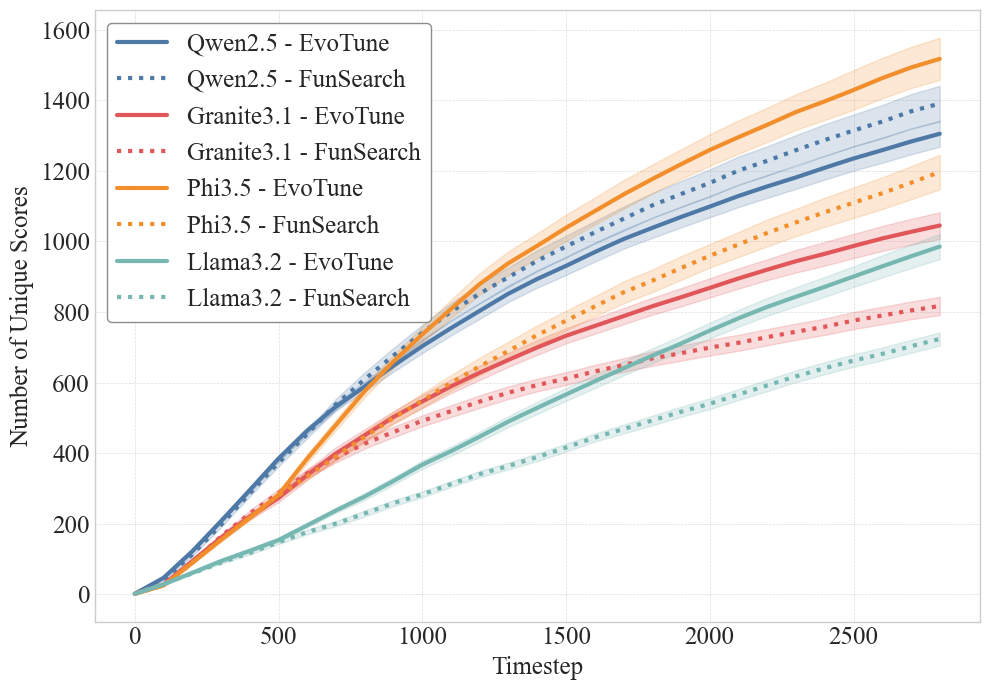

In [4]:
font_ticks = 18
font_axis = 18
figname = "unique_scores"

fig, ax = plt.subplots(figsize=(10, 7))

for label, data in averaged_metrics.items():
    model, identifier = label.split('-')
    plt.plot(
        data["round_num"],
        data["unique_scores"],
        label=legend_name_map.get(label, label),
        color=color_map[model],
        linestyle=line_style_map.get(identifier, "solid"),
        #marker=marker_map.get(identifier, "o"),
        linewidth=linewidth,
    )
    plt.fill_between(
        data["round_num"],
        data["unique_scores"] - data["std_error"],
        data["unique_scores"] + data["std_error"],
        color=color_map[model],
        alpha=0.2
    )
# Labels and title
ax.set_xlabel("Timestep", fontsize=font_axis, fontfamily=font_family)
ax.set_ylabel("Number of Unique Scores", fontsize=font_axis,fontfamily=font_family)

# Legend positioning outside the plot for clarity
# ax.legend(loc="upper left", fontsize=14)
# Add a legend with a visible frame
legend = ax.legend(loc="upper left", fontsize=font_ticks, frameon=True)
legend.get_frame().set_edgecolor("grey")  # Set frame color
legend.get_frame().set_alpha(0.9)  # Set legend transparency
for text in legend.get_texts():
    text.set_fontfamily(font_family)

# # Improve ticks and grid
ax.tick_params(axis="both", which="major", labelsize=font_ticks)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily(font_family)

# # Remove top and right spines
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

# Make left and bottom spines bold
# Tight layout to avoid overlap
plt.tight_layout()

# Save improved plot
plt.savefig(f"{task}_{figname}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{task}_{figname}.pdf", dpi=300, bbox_inches="tight")

# Display plot
plt.show()



In [5]:
del results
del averaged_metrics

In [29]:
metric_key = "Best 50 scores overall"

results = {
    "qwensmall":{qwensmallbest:[], "b":[]}, 
    "granite":{granitebest:[], "b":[]}, 
    "phi":{phibest:[], "b":[]},
    "llama32":{llama32best:[], "b":[]},        
    }


for model_name in results.keys():
    for sweep_identifier in results[model_name].keys():
        #model_name = "llama32"
        #sweep_identifier = "b" # "b", "s0", "s1", "s2""
        filters = {"config.config_specific": f"{num_models}m{model_name}{sweep_specifier}{sweep_identifier}"
                    , "config.task_name": task, "config.prefix": prefix} # "config.config_specific": "1llama32icmlb"
        runs = api.runs(entity + "/" + project, filters=filters)

        seeds = []
        for run in runs:
            print(run.name)
            seeds.append(run.config["seed"])
        seeds = list(set(seeds))

        histories = {}.fromkeys(seeds)
        histories = {seed: [] for seed in seeds}
        keys = [metric_key, "round_num"]
        for run in runs:
            # history = run.scan_history(keys=keys)
            history = run.history(keys=keys, pandas=True, samples=100, x_axis='round_num')
            s = run.config["seed"]
            histories[s].append(history)

        for seed in seeds:
            histories[seed] = copy.deepcopy([history for history in histories[seed] if not history.empty])
            # check if there are any duplicates, if there are drop the first row with the duplicate round_num
            for history in histories[seed]:
                history.drop_duplicates(subset="round_num", keep="last", inplace=True)
            assert all(histories[seed][i]["round_num"].duplicated().sum() == 0 for i in range(len(histories[seed]))), f"Seed {seed} has duplicates"

        for seed in seeds:
            if len(histories[seed]) != 1:    
                for i in range(1, len(histories[seed])):
                    print(seed, i)
                    histories[seed][i] = histories[seed][i].iloc[1:] if histories[seed][i].iloc[0]["round_num"] == histories[seed][i-1].iloc[-1]["round_num"] else histories[seed][i]
            histories[seed] = pd.concat(histories[seed])
            
        metrics = {}.fromkeys(keys)
        metrics = {key: [] for key in keys}

        for seed, history_df in histories.items():
            for key in keys:
                metrics[key].append(history_df[key].tolist())

        results[model_name][sweep_identifier] = metrics

# Average metrics over seeds and plot all in one figure
plt.figure(figsize=(10, 6))
averaged_metrics = {}

for model_name in results.keys():
    for sweep_identifier, metrics in results[model_name].items():
        round_nums = metrics["round_num"][0]
        unique_scores = metrics[metric_key]

        # Truncate based on max_round_num and exclude round_num == -1
        truncated_rounds = [rn for rn in round_nums if rn <= max_round_num ]
        truncated_unique_scores = [
            [score for rn, score in zip(metrics["round_num"][seed], unique_scores[seed]) if rn <= max_round_num]
            for seed in range(len(metrics["round_num"]))
        ]
        
        # Calculate average and standard error
        averaged = np.mean(truncated_unique_scores, axis=0)
        std_error = np.std(truncated_unique_scores, axis=0) / np.sqrt(len(truncated_unique_scores))
        
        # To fix the issue of the first round being -1
        truncated_rounds = truncated_rounds[1:]
        truncated_rounds.extend([truncated_rounds[-1] + 100])

        averaged_metrics[f"{model_name}-{sweep_identifier}"] = {
            "round_num": truncated_rounds,
            "unique_scores": averaged,
            "std_error": std_error
        }


sweepfinalicml/taskbin_1mqwensmallicmls0_0
sweepfinalicml/taskbin_1mqwensmallicmls0_1
sweepfinalicml/taskbin_1mqwensmallicmls0_2
sweepfinalicml/taskbin_1mqwensmallicmls0_3
sweepfinalicml/taskbin_1mqwensmallicmls0_4
sweepfinalicml/taskbin_1mqwensmallicmls0_6
sweepfinalicml/taskbin_1mqwensmallicmls0_5
sweepfinalicml/taskbin_1mqwensmallicmls0_7
sweepfinalicml/taskbin_1mqwensmallicmls0_8
sweepfinalicml/taskbin_1mqwensmallicmls0_9
sweepfinalicml/taskbin_1mqwensmallicmls0_0
sweepfinalicml/taskbin_1mqwensmallicmls0_1
sweepfinalicml/taskbin_1mqwensmallicmls0_2
sweepfinalicml/taskbin_1mqwensmallicmls0_3
sweepfinalicml/taskbin_1mqwensmallicmls0_4
sweepfinalicml/taskbin_1mqwensmallicmls0_5
sweepfinalicml/taskbin_1mqwensmallicmls0_6
sweepfinalicml/taskbin_1mqwensmallicmls0_7
sweepfinalicml/taskbin_1mqwensmallicmls0_8
sweepfinalicml/taskbin_1mqwensmallicmls0_9
sweepfinalicml/taskbin_1mqwensmallicmlb_0
sweepfinalicml/taskbin_1mqwensmallicmlb_1
sweepfinalicml/taskbin_1mqwensmallicmlb_2
sweepfinalicml

<Figure size 1000x600 with 0 Axes>

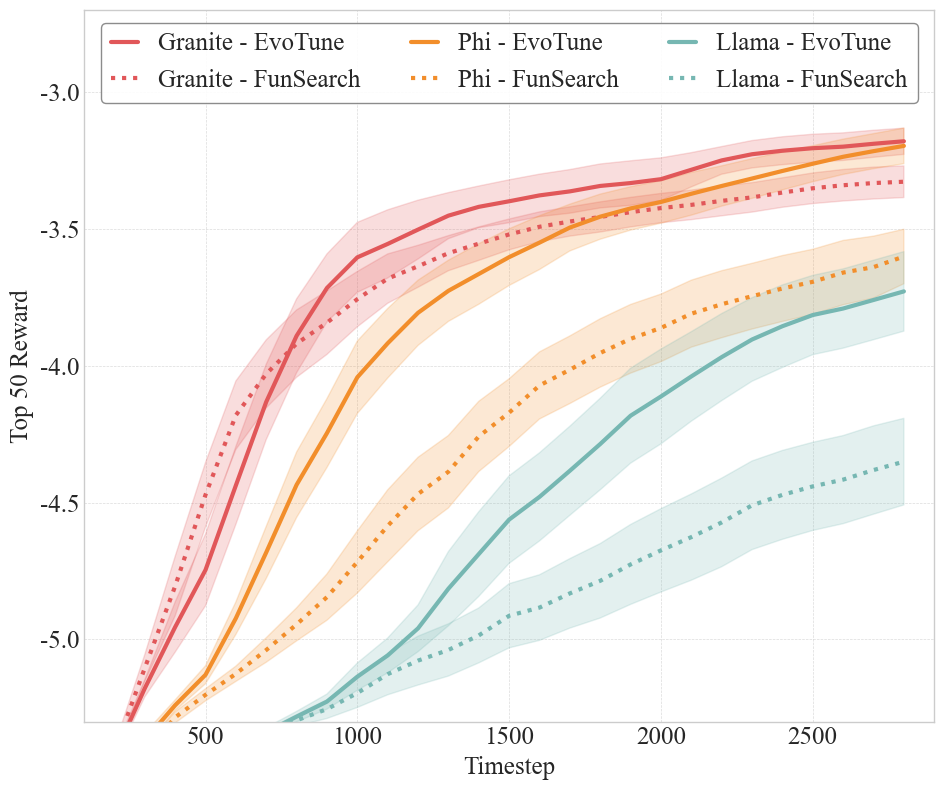

In [72]:
font_ticks = 18
font_axis = 18
figname = "best_50"

fig, ax = plt.subplots(figsize=(10, 8))


for label, data in averaged_metrics.items():
    if label == "qwensmall-b" or label == "qwensmall-s0":
        continue
    model, identifier = label.split('-')
    plt.plot(
        data["round_num"],
        data["unique_scores"],
        label=legend_name_map.get(label, label),
        color=color_map[model],
        linestyle=line_style_map.get(identifier, "solid"),
        # marker=marker_map.get(identifier, "o"), 
        linewidth=linewidth,
    )
    plt.fill_between(
        data["round_num"],
        data["unique_scores"] - data["std_error"],
        data["unique_scores"] + data["std_error"],
        color=color_map[model],
        alpha=0.2
    )
# Labels and title
ax.set_xlabel("Timestep", fontsize=font_axis, fontfamily=font_family)
ax.set_ylabel("Top 50 Reward", fontsize=font_axis,fontfamily=font_family)

# Legend positioning outside the plot for clarity
#Add a legend with a visible frame
legend = ax.legend(
    loc='upper center',         # place it above the plot
    # bbox_to_anchor=(0.5, 1.20), # adjust the y-value to move legend up/down
    ncol=3,                     # number of columns in the legend
    fontsize=font_ticks,
    frameon=True, 
    handlelength=1.1,        
)
#legend = ax.legend(loc="upper left", fontsize=font_ticks, frameon=True)
legend.get_frame().set_edgecolor("grey")  # Set frame color
legend.get_frame().set_alpha(0.9)  # Set legend transparency
for text in legend.get_texts():
    text.set_fontfamily(font_family)

# # Improve ticks and grid
ax.tick_params(axis="both", which="major", labelsize=font_ticks)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily(font_family)

# Tight layout to avoid overlap
plt.tight_layout()

# Define a formatter function that divides the axis value by 100
def scale_formatter(x, pos):
    return f"{x/100:.1f}"

# Apply this formatter to the y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(scale_formatter))

# Keep the original y-limits, so the plot itself doesn't move
ax.set_ylim([-530, -270])
ax.set_xlim([100, 2900])

# Save improved plot
plt.savefig(f"{task}_{figname}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{task}_{figname}.pdf", dpi=300, bbox_inches="tight")

# Display plot
plt.show()

In [9]:
del results
raise ValueError("Stop here")

In [20]:
metric_key = "avg_passed_true_score"

results = {
    "qwensmall":{qwensmallbest:[], "b":[]}, 
    "granite":{granitebest:[], "b":[]}, 
    "phi":{phibest:[], "b":[]},
    "llama32":{llama32best:[], "b":[]},        
    }


for model_name in results.keys():
    for sweep_identifier in results[model_name].keys():
        #model_name = "llama32"
        #sweep_identifier = "b" # "b", "s0", "s1", "s2""
        filters = {"config.config_specific": f"{num_models}m{model_name}{sweep_specifier}{sweep_identifier}"
                    , "config.task_name": task, "config.prefix": prefix} # "config.config_specific": "1llama32icmlb"
        runs = api.runs(entity + "/" + project, filters=filters)

        seeds = []
        for run in runs:
            print(run.name)
            seeds.append(run.config["seed"])
        seeds = list(set(seeds))

        histories = {}.fromkeys(seeds)
        histories = {seed: [] for seed in seeds}
        keys = [metric_key, "round_num"]
        for run in runs:
            # history = run.scan_history(keys=keys)
            history = run.history(keys=keys, pandas=True, samples=100, x_axis='round_num')
            s = run.config["seed"]
            histories[s].append(history)

        for seed in seeds:
            histories[seed] = copy.deepcopy([history for history in histories[seed] if not history.empty])
            # check if there are any duplicates, if there are drop the first row with the duplicate round_num
            for history in histories[seed]:
                history.drop_duplicates(subset="round_num", keep="last", inplace=True)
            assert all(histories[seed][i]["round_num"].duplicated().sum() == 0 for i in range(len(histories[seed]))), f"Seed {seed} has duplicates"

        for seed in seeds:
            if len(histories[seed]) != 1:    
                for i in range(1, len(histories[seed])):
                    print(seed, i)
                    histories[seed][i] = histories[seed][i].iloc[1:] if histories[seed][i].iloc[0]["round_num"] == histories[seed][i-1].iloc[-1]["round_num"] else histories[seed][i]
            histories[seed] = pd.concat(histories[seed])

        metrics = {}.fromkeys(keys)
        metrics = {key: [] for key in keys}

        for seed, history_df in histories.items():
            for key in keys:
                metrics[key].append(history_df[key].tolist())

        results[model_name][sweep_identifier] = metrics


# Average metrics over seeds and plot all in one figure
plt.figure(figsize=(10, 6))
averaged_metrics = {}

for model_name in results.keys():
    for sweep_identifier, metrics in results[model_name].items():
        round_nums = metrics["round_num"][0]
        unique_scores = metrics[metric_key]

        # Truncate based on max_round_num and exclude round_num == -1
        truncated_rounds = [rn for rn in round_nums if rn <= max_round_num ]
        truncated_unique_scores = [
            [score for rn, score in zip(metrics["round_num"][seed], unique_scores[seed]) if rn <= max_round_num]
            for seed in range(len(metrics["round_num"]))
        ]
        
        # Calculate average and standard error
        averaged = np.mean(truncated_unique_scores, axis=0)
        std_error = np.std(truncated_unique_scores, axis=0) / np.sqrt(len(truncated_unique_scores))
        
        # To fix the issue of the first round being -1
        truncated_rounds = truncated_rounds[1:]
        truncated_rounds.extend([truncated_rounds[-1] + 100])

        averaged_metrics[f"{model_name}-{sweep_identifier}"] = {
            "round_num": truncated_rounds,
            "unique_scores": averaged,
            "std_error": std_error
        }

sweepfinalicml/taskbin_1mqwensmallicmls0_0
sweepfinalicml/taskbin_1mqwensmallicmls0_1
sweepfinalicml/taskbin_1mqwensmallicmls0_2
sweepfinalicml/taskbin_1mqwensmallicmls0_3
sweepfinalicml/taskbin_1mqwensmallicmls0_4
sweepfinalicml/taskbin_1mqwensmallicmls0_6
sweepfinalicml/taskbin_1mqwensmallicmls0_5
sweepfinalicml/taskbin_1mqwensmallicmls0_7
sweepfinalicml/taskbin_1mqwensmallicmls0_8
sweepfinalicml/taskbin_1mqwensmallicmls0_9
sweepfinalicml/taskbin_1mqwensmallicmls0_0
sweepfinalicml/taskbin_1mqwensmallicmls0_1
sweepfinalicml/taskbin_1mqwensmallicmls0_2
sweepfinalicml/taskbin_1mqwensmallicmls0_3
sweepfinalicml/taskbin_1mqwensmallicmls0_4
sweepfinalicml/taskbin_1mqwensmallicmls0_5
sweepfinalicml/taskbin_1mqwensmallicmls0_6
sweepfinalicml/taskbin_1mqwensmallicmls0_7
sweepfinalicml/taskbin_1mqwensmallicmls0_8
sweepfinalicml/taskbin_1mqwensmallicmls0_9
sweepfinalicml/taskbin_1mqwensmallicmlb_0
sweepfinalicml/taskbin_1mqwensmallicmlb_1
sweepfinalicml/taskbin_1mqwensmallicmlb_2
sweepfinalicml

<Figure size 1000x600 with 0 Axes>

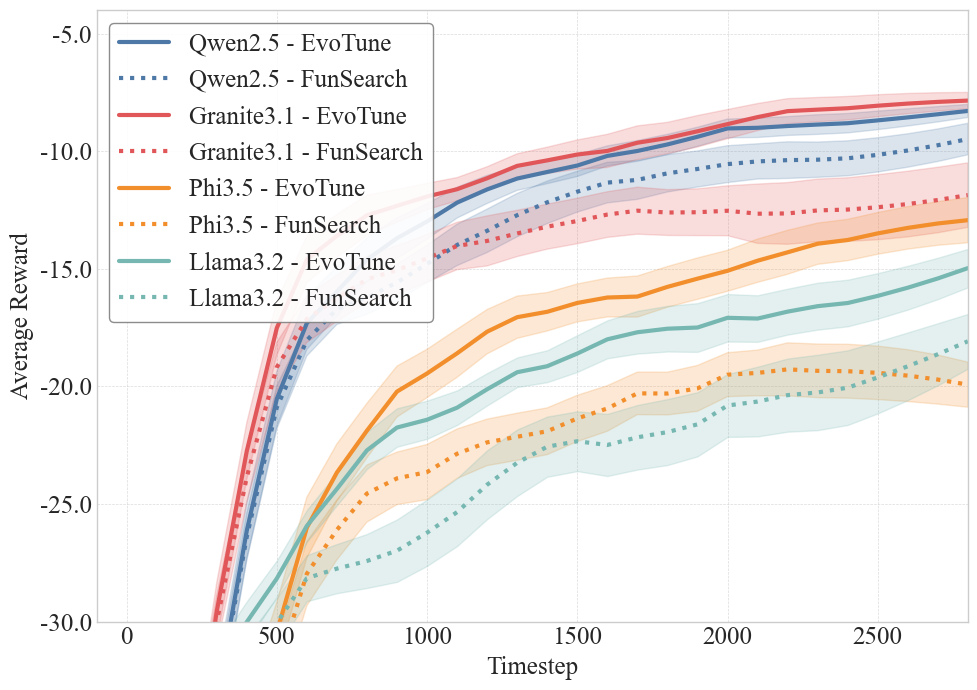

In [28]:
font_ticks = 18
font_axis = 18
figname = "avg_reward"


fig, ax = plt.subplots(figsize=(10, 7))

from scipy.signal import savgol_filter
for label, data in averaged_metrics.items():
    model, identifier = label.split('-')
    smoothed_scores = savgol_filter(data["unique_scores"], window_length=10, polyorder=2)
    smoothed_std_error = savgol_filter(data["std_error"], window_length=10, polyorder=2)
    plt.plot(
        data["round_num"],
        smoothed_scores,
        label=legend_name_map.get(label, label),
        color=color_map[model],
        linestyle=line_style_map.get(identifier, "solid"),
        linewidth=linewidth,
    )
    plt.fill_between(
        data["round_num"],
        smoothed_scores - smoothed_std_error,
        smoothed_scores + smoothed_std_error,
        color=color_map[model],
        alpha=0.2
            )
# Labels and title
ax.set_xlabel("Timestep", fontsize=font_axis, fontfamily=font_family)
ax.set_ylabel("Average Reward", fontsize=font_axis,fontfamily=font_family)

# Add a legend with a visible frame
legend = ax.legend(loc="upper left", fontsize=font_ticks, frameon=True)
legend.get_frame().set_edgecolor("grey")  # Set frame color
legend.get_frame().set_alpha(0.9)  # Set legend transparency
for text in legend.get_texts():
    text.set_fontfamily(font_family)

# # Improve ticks and grid
ax.tick_params(axis="both", which="major", labelsize=font_ticks)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily(font_family)

# Tight layout to avoid overlap
plt.tight_layout()

# # Define a formatter function that divides the axis value by 100
def scale_formatter(x, pos):
    return f"{x/100:.1f}"

# Apply this formatter to the y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(scale_formatter))

# Keep the original y-limits, so the plot itself doesn't move
ax.set_ylim([-3000, -400])
ax.set_xlim([-100, 2800])

# Set y-axis formatter to divide labels by 100
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: x / 100))

# Save improved plot
plt.savefig(f"{task}_{figname}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{task}_{figname}.pdf", dpi=300, bbox_inches="tight")

# Display plot
plt.show()
